In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tabulate import tabulate
import seaborn as sns
import scikitplot as skplt
from numpy import percentile
import math

#pandas
from pandas.plotting import parallel_coordinates
from datetime import date, datetime

#sklearn
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, RobustScaler, StandardScaler

from sklearn.decomposition import PCA
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import learning_curve

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix, roc_curve, auc
from sklearn.metrics import roc_auc_score, precision_score, recall_score, make_scorer
from sklearn.metrics import plot_confusion_matrix

from sklearn.neighbors import KNeighborsClassifier

#scikitplot
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_lift_curve
from scikitplot.metrics import plot_cumulative_gain

#mlxtend
from mlxtend.plotting import plot_decision_regions

#collections
from collections import Counter

#imblearn
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler, CondensedNearestNeighbour, TomekLinks, OneSidedSelection

#matplotlib
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import pyplot

#seaborn
import seaborn as sns

#scipy
import scipy.stats as stats
from scipy.stats import shapiro, mannwhitneyu, normaltest, kstest
from scipy.stats import boxcox, yeojohnson

#json
import json

In [2]:
def draw_confusion_matrix(clf, X, y, type_flag):
    
    titles_options = [("Confusion matrix, without normalization on %s" %(type_flag), None),
                  ("Normalized confusion matrix on %s" %(type_flag), 'true')]
    
    for title, normalize in titles_options:
        disp = plot_confusion_matrix(clf, X, y,
                                 cmap='OrRd',
                                 normalize=normalize)
        disp.ax_.set_title(title)
    
    plt.show()

In [3]:
def draw_roc_curve(y_test, y_pred, type_flag):
    
    fig, ax = plt.subplots() #figsize = (13,30)
    
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    roc_auc = roc_auc_score(y_test, y_pred, average=None)
    
    ax.plot(fpr, tpr, color = "#ff7400", label='ROC curve (area = %0.2f)' % (roc_auc))
    ax.plot([0, 1], [0, 1], 'k--', color = '#b42cf0')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate') 
    ax.set_title('Roc curve of the model on %s' %(type_flag))
    ax.tick_params(axis='both')
    ax.legend(loc="lower right", fontsize=14, frameon=False)
    
    fig.tight_layout()
    
    plt.show()

In [4]:
def get_metrics(y_test, y_pred):

    metrics = []
    metrics_names = []

    acc = accuracy_score(y_test, y_pred)
    acc = [float('%.2f' % acc)]
    acc_name = accuracy_score.__name__
    metrics.append(acc)
    metrics_names.append(acc_name)

    f1 = f1_score(y_test, y_pred, labels = [0, 1], average='weighted', zero_division = 1)
    f1 = [float('%.2f' % f1)]
    f1_name = f1_score.__name__
    metrics.append(f1)
    metrics_names.append(f1_name)

    prec = precision_score(y_test, y_pred, labels = [0, 1], average = 'weighted', zero_division= 1)        
    prec = [float('%.2f' % prec)]
    prec_name = precision_score.__name__
    metrics.append(prec)
    metrics_names.append(prec_name)

    rec = recall_score(y_test, y_pred, labels = [0, 1], average = 'weighted', zero_division = 1)
    rec = [float('%.2f' % rec)]
    rec_name = recall_score.__name__
    metrics.append(rec)
    metrics_names.append(rec_name)
    
    
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    
    fpr = [fpr.tolist()]
    fpr_name = 'fpr'
    metrics.append(fpr)
    metrics_names.append(fpr_name)
    
    tpr = [tpr.tolist()]
    tpr_name = 'tpr'
    metrics.append(tpr)
    metrics_names.append(tpr_name)

    auc_score = roc_auc_score(y_test, y_pred, average = None)
    auc_score = [float('%.2f' % auc_score)]
    auc_name = roc_auc_score.__name__
    metrics.append(auc_score)
    metrics_names.append(auc_name)

    metrics = np.array(metrics, dtype = object)
    
    return metrics, metrics_names

In [5]:
def plot_metrics_table(cm, target_names, type_flag, cmap=plt.cm.Pastel1):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    title = 'Metrics of ' + type_flag
    plt.title(title, fontsize=13)
    tick_marks_x = np.arange(0)
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks_x)
    plt.yticks(tick_marks, target_names, fontsize = 12)
    
    plt.tight_layout()

    width, height = cm.shape
    
    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center', fontsize = 11)
    
    plt.show()

<h1>Divide into features and target</h1>

<h2>Training merged</h2>

In [6]:
X_train_merged = pd.read_csv('X_train_merged.csv', index_col=0)
y_train = pd.read_csv('y_train_merged.csv', index_col=0)

In [7]:
print("Original Training merged:", X_train_merged.shape)

Original Training merged: (92834, 55)


In [8]:
numeric_columns = []  # continous variables
for column_name in X_train_merged.columns:
    if ("track_genre_top" not in column_name) and  \
          ("track_date_created_year" not in column_name) and \
            ("track_date_created_season" not in column_name):
                numeric_columns.append(column_name)
print("numeric_columns", len(numeric_columns))

numeric_columns 37


In [9]:
for column in X_train_merged:
    if column not in numeric_columns:
        X_train_merged = X_train_merged.drop(column, axis = 1)
        
print("New Training merged:", X_train_merged.shape) 

New Training merged: (92834, 37)


**X_train_merged with numeric columns with a normal distribution**

In [10]:
X_train_merged_norm = X_train_merged.apply(lambda x: yeojohnson(x)[0])

In [11]:
print("Training merged norm shape:", X_train_merged_norm.shape)

Training merged norm shape: (92834, 37)


<h2>Test</h2>

In [12]:
X_test = pd.read_csv('X_test.csv', index_col=0)
y_test = pd.read_csv('y_test.csv', index_col=0)

In [13]:
print("Original Test:", X_test.shape)

Original Test: (10874, 55)


In [14]:
numeric_columns = []  # continous variables
for column_name in X_test.columns:
    if ("track_genre_top" not in column_name) and  \
          ("track_date_created_year" not in column_name) and \
            ("track_date_created_season" not in column_name):
                numeric_columns.append(column_name)
print("numeric_columns", len(numeric_columns))

numeric_columns 37


In [15]:
for column in X_test:
    if column not in numeric_columns:
        X_test = X_test.drop(column, axis = 1)
        
print("New Test:", X_test.shape)    

New Test: (10874, 37)


In [16]:
X_test = X_test.values

In [17]:
def plot_decision_boundary(X_tr, y_tr, model, type_flag):
    
    pca = PCA(n_components=2)
    best_visualization_scaler = StandardScaler()
    
    scaled_X_tr = best_visualization_scaler.fit_transform(X_tr)
    X = pca.fit_transform(scaled_X_tr)
    y = y_tr.values.ravel()

    model.fit(X, y)
    
    fig = plot_decision_regions(X=X, y=y, clf=model, legend=2)
    plt.xlabel("PCA component 1")
    plt.ylabel("PCA component 2")
    plt.title("Model's %s decision boundary" % (type_flag))
    plt.legend(loc='best')
    plt.show()

In [18]:
def plot_selected_features_anova(X_tr, clf, best_params, type_flag):
    
    dfscores = pd.DataFrame(clf['reduce_dim'].scores_)
    dfcolumns = pd.DataFrame(X_tr.columns)

    featureScores = pd.concat([dfcolumns, dfscores], axis = 1)
    featureScores.columns = ['Feature', 'Score']
    featureScores = featureScores[featureScores['Score'] != 0]

    best_k = best_params['reduce_dim__k']
    
    # plot feature importance
    fig = plt.figure(figsize=(8, 10))
    
    # keeping ongly best_k features, ordered in descending score
    ordered_k_feature_scores = featureScores.sort_values('Score', ascending=False).iloc[:best_k]
    
    sns.barplot(y='Feature', x='Score', data=featureScores, color= "#ff7400",
                                                            order=ordered_k_feature_scores.Feature)
    
    plt.title("%s feature importance using %s" % (type_flag, 'ANOVA'))
    plt.show()

In [19]:
def plot_classification_report(y_test, y_pred, type_flag):
    
    model_report = classification_report(y_test, y_pred, output_dict=True)
    
    model_r = pd.DataFrame(model_report).iloc[:-1, :].T
    
    sns.heatmap(model_r, annot=True, cmap='OrRd', cbar=False)
    
    plt.title("%s classification report" % (type_flag))
    
    plt.show()

<h2>Analysis</h2>

**Scalers to test**

In [20]:
scalers_to_test = [MinMaxScaler(), MaxAbsScaler(), RobustScaler(), StandardScaler()]

**Define pipelines**

In [21]:
def get_pipelines(model):
    
    pipelines_tot = []
    
    #RandomUnderSampler
    pipelines_ru = []
    
    p1 = Pipeline([('under', RandomUnderSampler()),
                   ('scaler', 'passthrough'),
                   ('knn', model)])
    pipelines_ru.append(('RandomUnderSampler', 'NO_feature_selection', p1))
    
    p2 = Pipeline([('under', RandomUnderSampler()),
                   ('scaler', 'passthrough'),
                   ('reduce_dim', 'passthrough'),
                   ('knn', model)])
    pipelines_ru.append(('RandomUnderSampler', 'Feature_selection', p2))
    
    pipelines_tot.append(pipelines_ru)
    
    
    #TomekLinks
    pipelines_tl = []
    
    p3 = Pipeline([('under', TomekLinks(n_jobs = -1)),
                   ('scaler', 'passthrough'),
                   ('knn', model)])
    pipelines_tl.append(('TomekLinks', 'NO_feature_selection', p3))
    
    p4 = Pipeline([('under', TomekLinks(n_jobs = -1)),
                   ('scaler', 'passthrough'),
                   ('reduce_dim', 'passthrough'),
                   ('knn', model)])
    pipelines_tl.append(('TomekLinks', 'Feature_selection', p4))
    
    pipelines_tot.append(pipelines_tl)
    
    
    #OneSidedSelection
    pipelines_oss = []
    
    p5 = Pipeline([('under', OneSidedSelection(random_state = 42, n_jobs = -1)),
                   ('scaler', 'passthrough'),
                   ('knn', model)])
    pipelines_oss.append(('OneSidedSelection', 'NO_feature_selection', p5))
    
    p6 = Pipeline([('under', OneSidedSelection(random_state = 42, n_jobs = -1)),
                   ('scaler', 'passthrough'),
                   ('reduce_dim', 'passthrough'),
                   ('knn', model)])
    pipelines_oss.append(('OneSidedSelection', 'Feature_selection', p6))
                         
    pipelines_tot.append(pipelines_oss)
    
    return pipelines_tot

**Define the hyperparameters to tune**

In [22]:
sqrt_records = round(math.sqrt(X_train_merged.shape[0]))
k_range = list(range(3, sqrt_records*2, 2))


params1 = {'scaler': scalers_to_test,
                  'knn__n_neighbors': k_range,
                  'knn__weights': ['uniform', 'distance'],
                  'knn__p': [1, 2]}

params2 = [
                  {'scaler': scalers_to_test,
                  'reduce_dim': [SelectKBest(f_classif)],
                  'reduce_dim__k': [i+1 for i in range(X_train_merged.shape[1])],
                  'knn__n_neighbors': k_range,
                  'knn__weights': ['uniform', 'distance'],
                  'knn__p': [1, 2]},

                  {'scaler': scalers_to_test,
                  'reduce_dim': [PCA()],
                  'reduce_dim__n_components': [i+1 for i in range(X_train_merged.shape[1])],
                  'knn__n_neighbors': k_range,
                  'knn__weights': ['uniform', 'distance'],
                  'knn__p': [1, 2]},

                  {'scaler': scalers_to_test,
                   'reduce_dim': [SequentialFeatureSelector(KNeighborsClassifier())],
                   'reduce_dim__n_features_to_select': [i+1 for i in range(X_train_merged.shape[1])],
                   'reduce_dim__scoring': 'f1_weighted',
                   'knn__n_neighbors': k_range,
                   'knn__weights': ['uniform', 'distance'],
                   'knn__p': [1, 2]}
                  ]

**Randomized Grid Search CV (Validation)**

Fitting 3 folds for each of 10 candidates, totalling 30 fits
RandomUnderSampler
NO_feature_selection

{'scaler': MaxAbsScaler(), 'knn__weights': 'distance', 'knn__p': 2, 'knn__n_neighbors': 89}
Pipeline(steps=[('under', RandomUnderSampler()), ('scaler', MaxAbsScaler()),
                ('knn',
                 KNeighborsClassifier(n_neighbors=89, weights='distance'))])
Confusion matrix


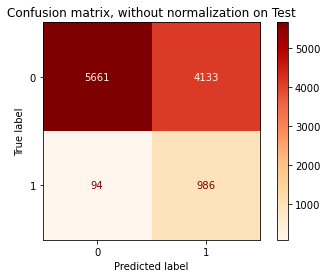

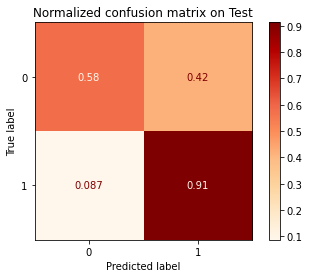

Classification report
              precision    recall  f1-score   support

           0       0.98      0.58      0.73      9794
           1       0.19      0.91      0.32      1080

    accuracy                           0.61     10874
   macro avg       0.59      0.75      0.52     10874
weighted avg       0.91      0.61      0.69     10874




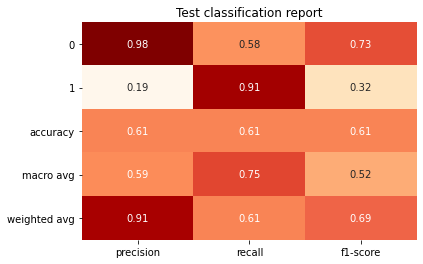

Metrics


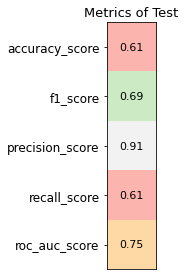



Roc curve



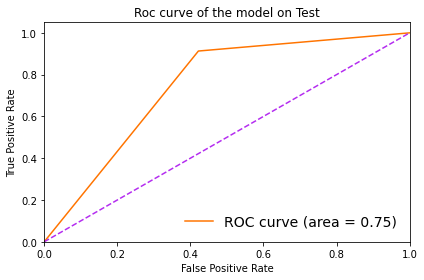


Lift Curve


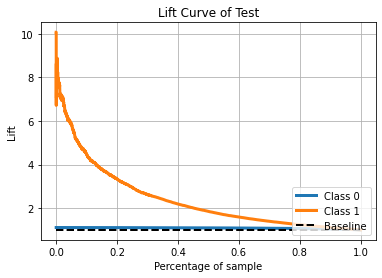

Roc Curves


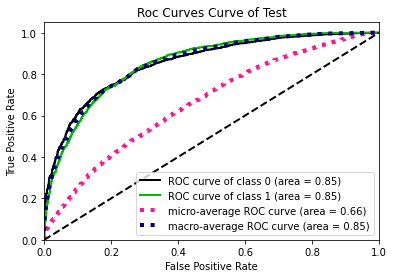

Precision Recall Curve


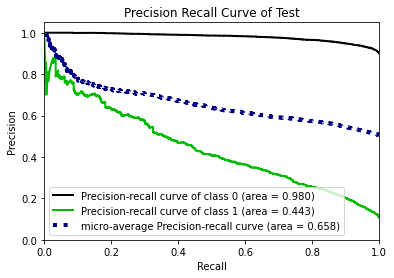

Cumulative Gains Curve


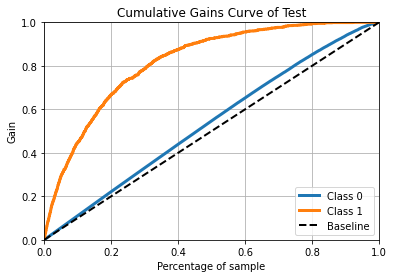

Decision boundary


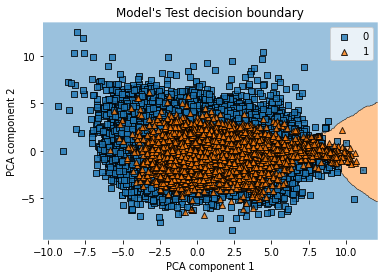

------------------------------------------------------------------------------------------------------

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.66532905        nan 0.48923515        nan        nan 0.64391576
        nan        nan        nan        nan]
  warnings.warn(


RandomUnderSampler
Feature_selection

{'scaler': RobustScaler(), 'reduce_dim__k': 26, 'reduce_dim': SelectKBest(k=26), 'knn__weights': 'distance', 'knn__p': 2, 'knn__n_neighbors': 13}
Pipeline(steps=[('under', RandomUnderSampler()), ('scaler', RobustScaler()),
                ('reduce_dim', SelectKBest(k=26)),
                ('knn',
                 KNeighborsClassifier(n_neighbors=13, weights='distance'))])
Selected features


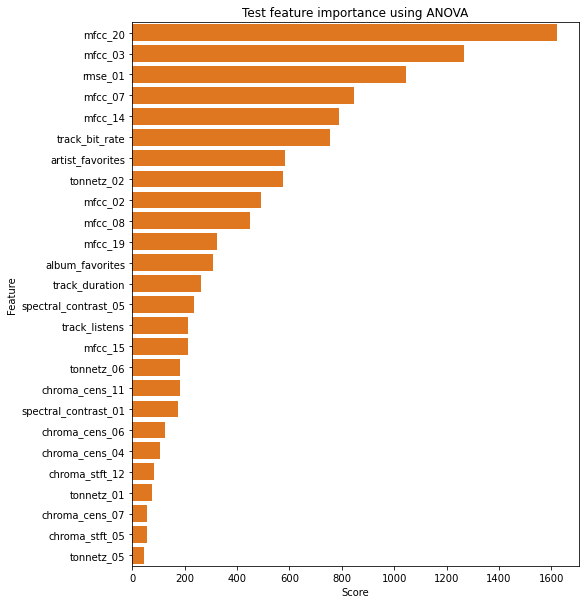


Confusion matrix


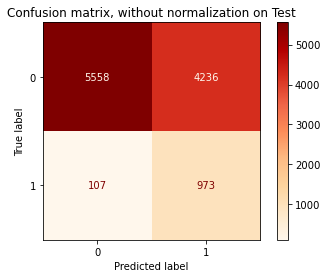

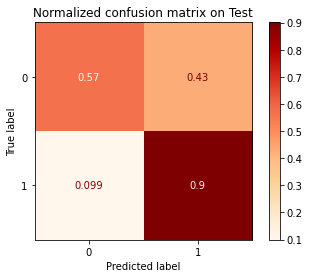

Classification report
              precision    recall  f1-score   support

           0       0.98      0.57      0.72      9794
           1       0.19      0.90      0.31      1080

    accuracy                           0.60     10874
   macro avg       0.58      0.73      0.51     10874
weighted avg       0.90      0.60      0.68     10874




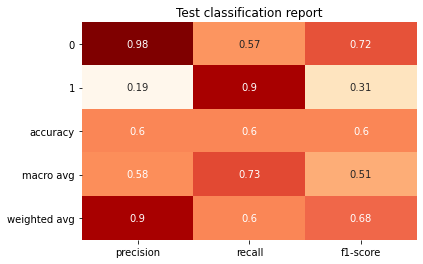

Metrics


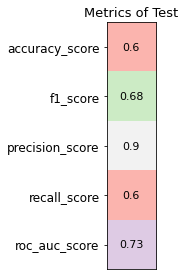



Roc curve



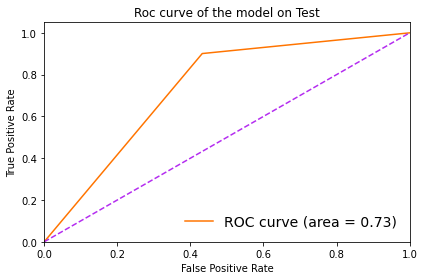


Lift Curve


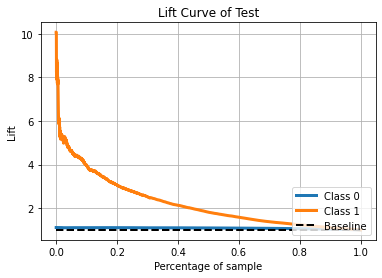

Roc Curves


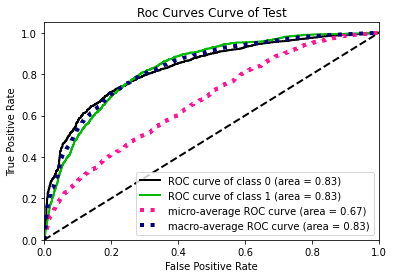

Precision Recall Curve


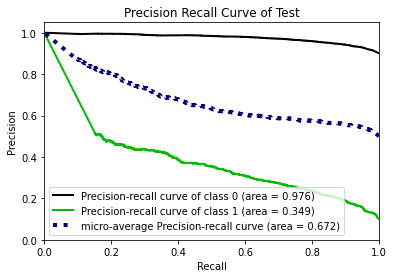

Cumulative Gains Curve


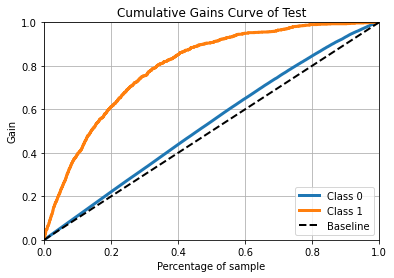

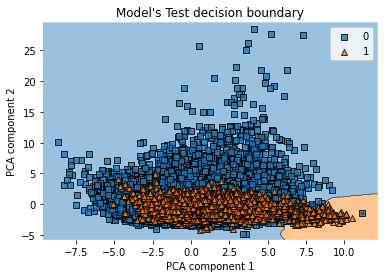

------------------------------------------------------------------------------------------------------

''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

Fitting 3 folds for each of 10 candidates, totalling 30 fits
TomekLinks
NO_feature_selection

{'scaler': MinMaxScaler(), 'knn__weights': 'uniform', 'knn__p': 1, 'knn__n_neighbors': 255}
Pipeline(steps=[('under', TomekLinks(n_jobs=-1)), ('scaler', MinMaxScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=255, p=1))])
Confusion matrix


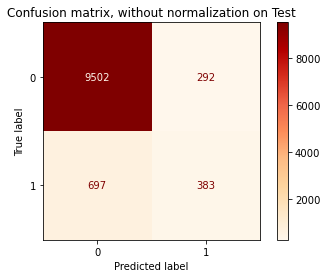

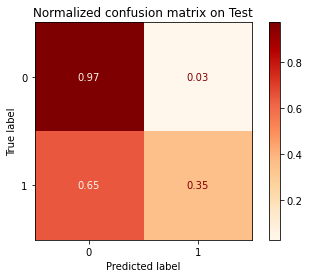

Classification report
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      9794
           1       0.57      0.35      0.44      1080

    accuracy                           0.91     10874
   macro avg       0.75      0.66      0.69     10874
weighted avg       0.90      0.91      0.90     10874




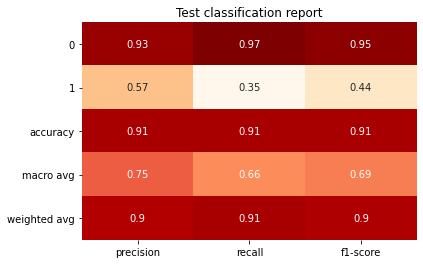

Metrics


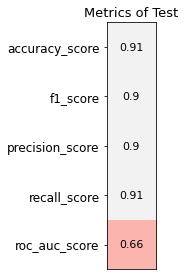



Roc curve



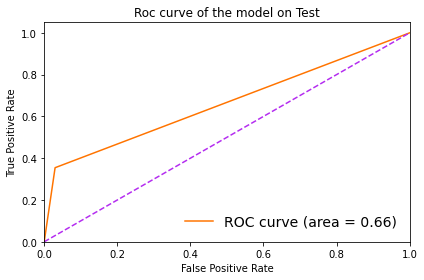


Lift Curve


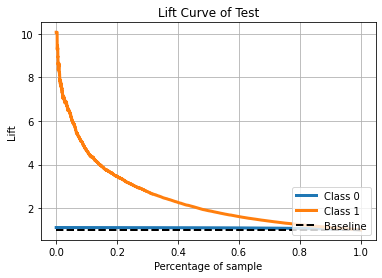

Roc Curves


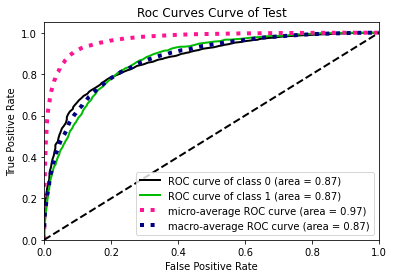

Precision Recall Curve


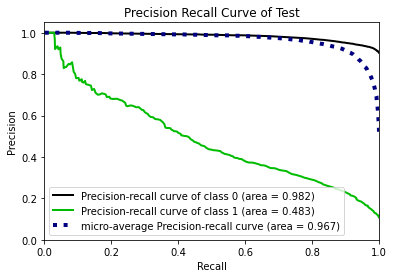

Cumulative Gains Curve


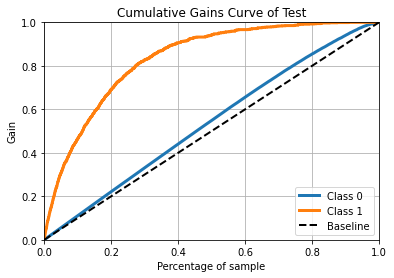

Decision boundary


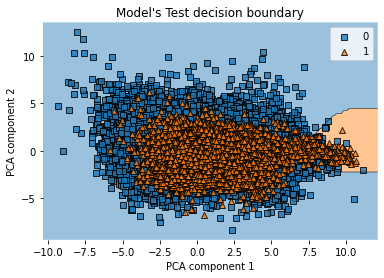

------------------------------------------------------------------------------------------------------

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan 0.87015623
 0.88611377 0.87265988        nan        nan]
  warnings.warn(


TomekLinks
Feature_selection

{'scaler': MaxAbsScaler(), 'reduce_dim__k': 12, 'reduce_dim': SelectKBest(k=12), 'knn__weights': 'distance', 'knn__p': 2, 'knn__n_neighbors': 147}
Pipeline(steps=[('under', TomekLinks(n_jobs=-1)), ('scaler', MaxAbsScaler()),
                ('reduce_dim', SelectKBest(k=12)),
                ('knn',
                 KNeighborsClassifier(n_neighbors=147, weights='distance'))])
Selected features


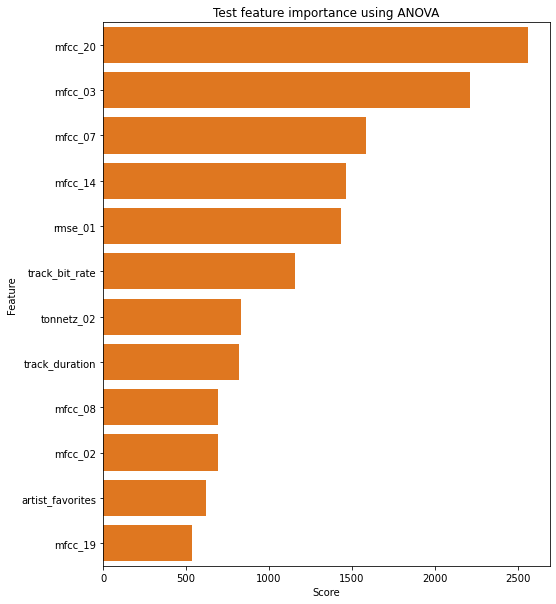


Confusion matrix


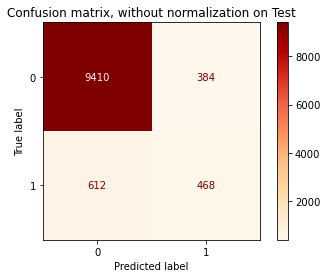

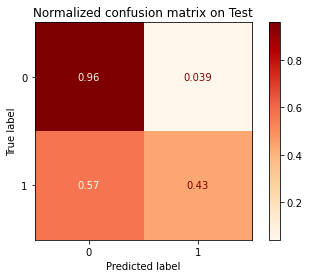

Classification report
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      9794
           1       0.55      0.43      0.48      1080

    accuracy                           0.91     10874
   macro avg       0.74      0.70      0.72     10874
weighted avg       0.90      0.91      0.90     10874




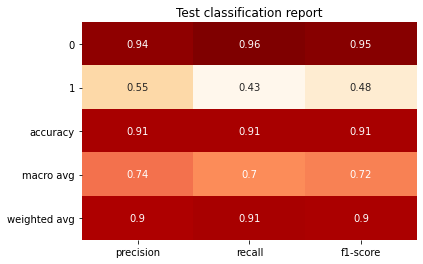

Metrics


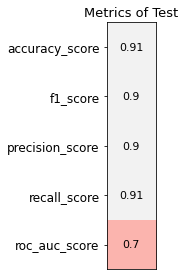



Roc curve



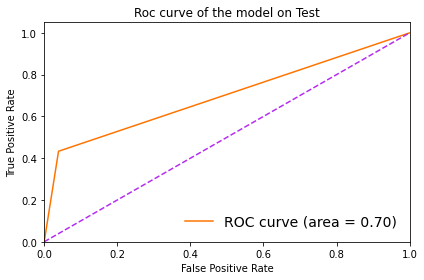


Lift Curve


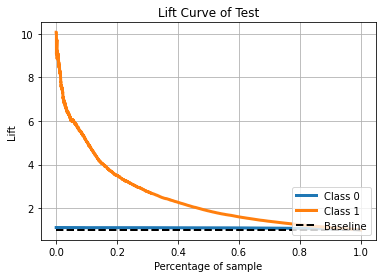

Roc Curves


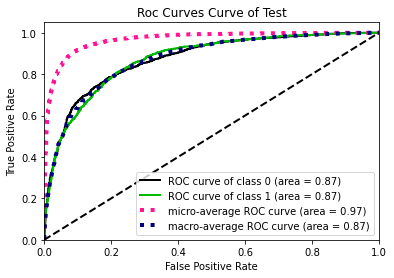

Precision Recall Curve


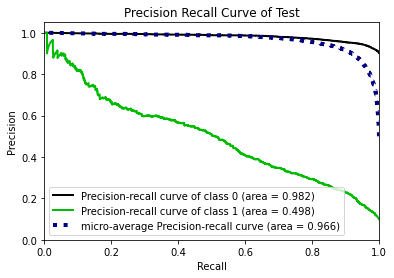

Cumulative Gains Curve


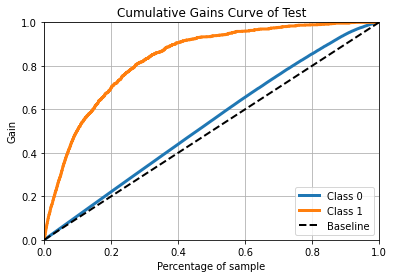

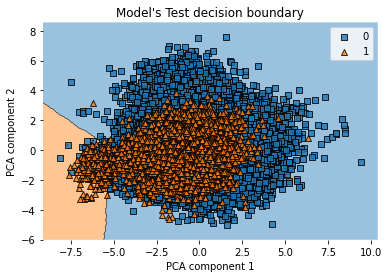

------------------------------------------------------------------------------------------------------

''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

Fitting 3 folds for each of 10 candidates, totalling 30 fits
OneSidedSelection
NO_feature_selection

{'scaler': MaxAbsScaler(), 'knn__weights': 'distance', 'knn__p': 1, 'knn__n_neighbors': 197}
Pipeline(steps=[('under', OneSidedSelection(n_jobs=-1, random_state=42)),
                ('scaler', MaxAbsScaler()),
                ('knn',
                 KNeighborsClassifier(n_neighbors=197, p=1,
                                      weights='distance'))])
Confusion matrix


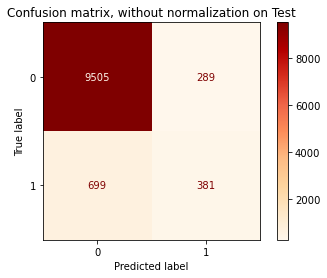

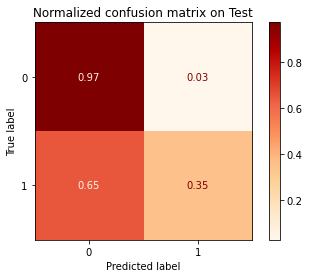

Classification report
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      9794
           1       0.57      0.35      0.44      1080

    accuracy                           0.91     10874
   macro avg       0.75      0.66      0.69     10874
weighted avg       0.90      0.91      0.90     10874




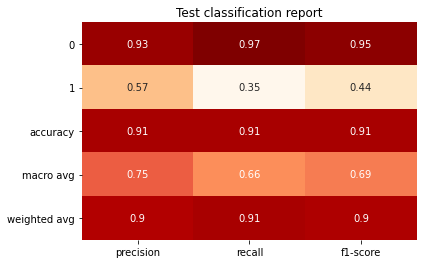

Metrics


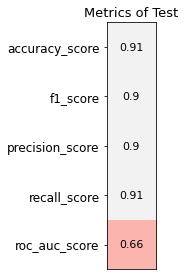



Roc curve



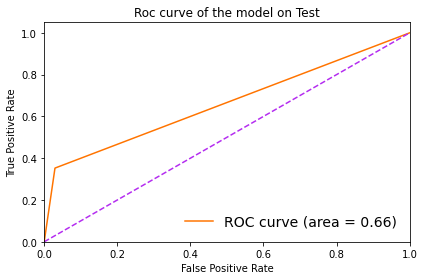


Lift Curve


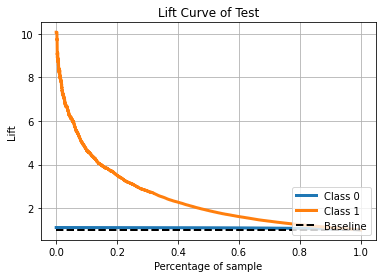

Roc Curves


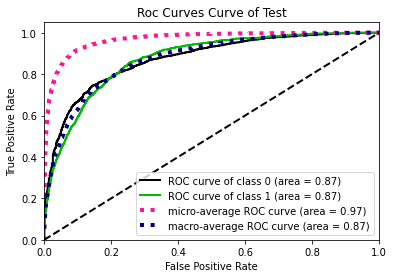

Precision Recall Curve


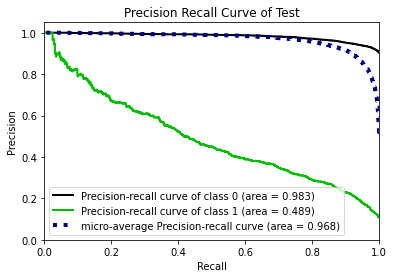

Cumulative Gains Curve


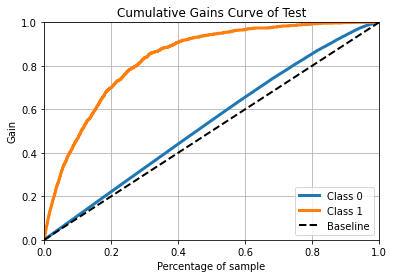

Decision boundary


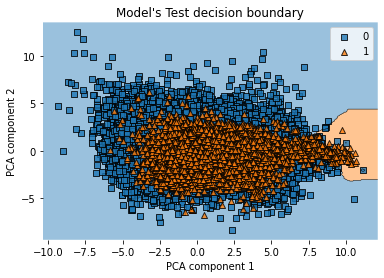

------------------------------------------------------------------------------------------------------

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.87063152        nan        nan        nan
        nan        nan        nan        nan]
  warnings.warn(


OneSidedSelection
Feature_selection

{'scaler': RobustScaler(), 'reduce_dim__k': 28, 'reduce_dim': SelectKBest(k=28), 'knn__weights': 'uniform', 'knn__p': 1, 'knn__n_neighbors': 453}
Pipeline(steps=[('under', OneSidedSelection(n_jobs=-1, random_state=42)),
                ('scaler', RobustScaler()), ('reduce_dim', SelectKBest(k=28)),
                ('knn', KNeighborsClassifier(n_neighbors=453, p=1))])
Selected features


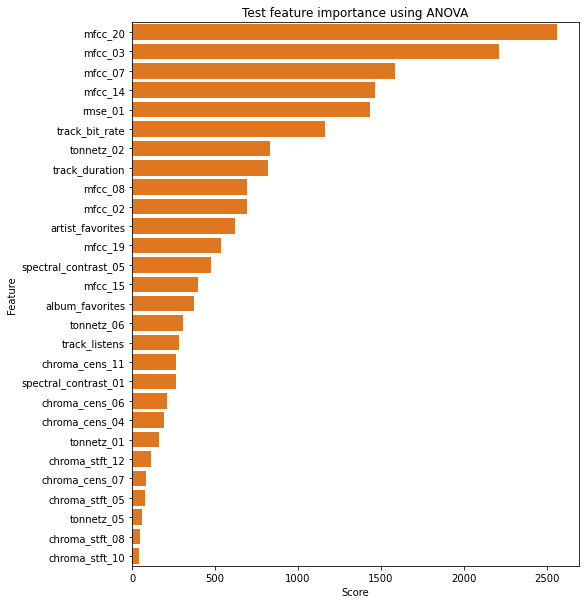


Confusion matrix


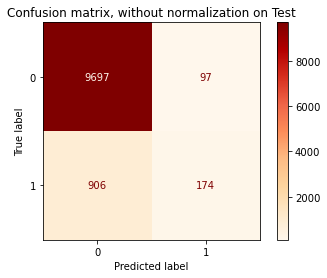

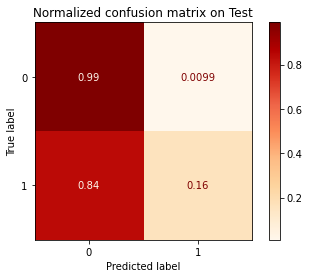

Classification report
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      9794
           1       0.64      0.16      0.26      1080

    accuracy                           0.91     10874
   macro avg       0.78      0.58      0.60     10874
weighted avg       0.89      0.91      0.88     10874




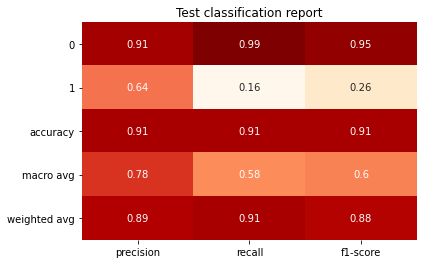

Metrics


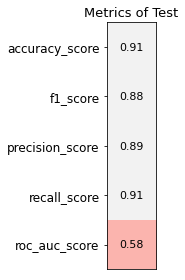



Roc curve



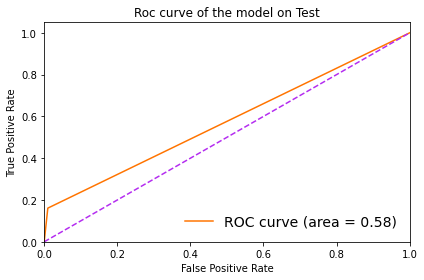


Lift Curve


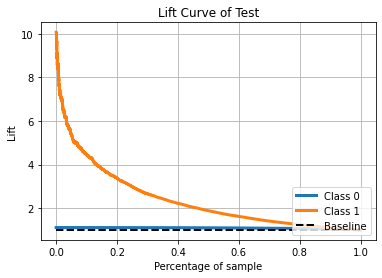

Roc Curves


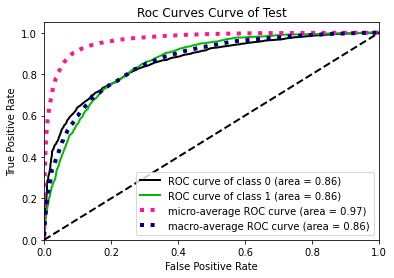

Precision Recall Curve


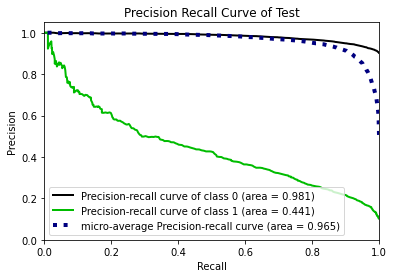

Cumulative Gains Curve


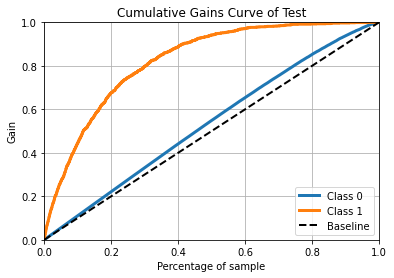

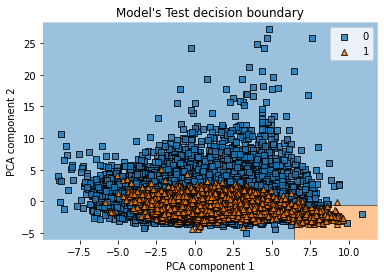

------------------------------------------------------------------------------------------------------

''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''



In [23]:
dict_pipelines= {}

model = KNeighborsClassifier()
pipelines_tot = get_pipelines(model)
type_flag = "Test"


for element in pipelines_tot:
    dict_pipelines[element[0][0]] = {}    #dictionary of undersampling method
    for (under_sampling_type, name, pipeline) in element:
    
        if name == 'NO_feature_selection':
            params = params1
        else:
            params = params2

        k_fold = StratifiedKFold(n_splits=3) 

        randomized_search = RandomizedSearchCV(pipeline, param_distributions = params, scoring = 'f1_weighted', cv = k_fold, refit = 'f1_weighted', verbose = True, n_jobs = -1, n_iter = 10)

        if name == 'Feature_selection':
            if isinstance(pipeline.steps[2][1], SelectKBest):
                X_train = X_train_merged_norm.values
            else:
                X_train = X_train_merged.values
        else:
            X_train = X_train_merged.values

        randomized_search.fit(X_train, y_train.values.ravel())

        print('\033[1m'+under_sampling_type+'\033[0m')
        print('\033[1m'+name+'\033[0m')
        print()

        print(randomized_search.best_params_)
        print(randomized_search.best_estimator_)

        best_params = randomized_search.best_params_
        clf = randomized_search.best_estimator_

        y_pred = clf.predict(X_test)
        y_score = clf.predict_proba(X_test)

        metrics, metrics_names = get_metrics(y_test, y_pred)

        dict_pipelines[element[0][0]][name] = {}
        for m, n in zip(metrics, metrics_names):
            dict_pipelines[element[0][0]][name][n] = m[0]

        dict_pipelines[element[0][0]][name]['model'] = clf
        dict_pipelines[element[0][0]][name]['best_params'] = best_params

        #plot selected features (only if reduce_dim == SelectKBest)
        if name == 'Feature_selection':
            if isinstance(clf['reduce_dim'], SelectKBest):
                print('\033[1m'"Selected features"'\033[0m')
                plot_selected_features_anova(X_train_merged, clf, best_params, type_flag)
                print()

        #confusion matrix
        print('\033[1m'"Confusion matrix"'\033[0m')
        draw_confusion_matrix(clf, X_test, y_test, type_flag)

        #classification report
        print('\033[1m'"Classification report"'\033[0m')
        print(classification_report(y_test, y_pred))
        print()
        plot_classification_report(y_test, y_pred, type_flag)

        #metrics
        metrics2 = [i for i in metrics]
        metrics2.pop(4)
        metrics2.pop(4)
        metrics2 = np.array(metrics2, dtype = float)
        
        metrics_names2 = [i for i in metrics_names]
        metrics_names2.remove('fpr')
        metrics_names2.remove('tpr')
        
        print('\033[1m'"Metrics"'\033[0m')
        plot_metrics_table(metrics2, metrics_names2, type_flag)

        print()
        print()

        #roc curve
        print('\033[1m'"Roc curve"'\033[0m')
        print()
        draw_roc_curve(y_test, y_pred, type_flag)

        print()

        #lift curve
        print('\033[1m'"Lift Curve"'\033[0m')
        title = "Lift Curve of " + type_flag
        plot_lift_curve(y_test, y_score, title)
        plt.show()

        #roc curves
        print('\033[1m'"Roc Curves"'\033[0m')
        title = "Roc Curves Curve of " + type_flag
        plot_roc(y_test, y_score, title)
        plt.show()

        #precision-recall curve
        print('\033[1m'"Precision Recall Curve"'\033[0m')
        title = "Precision Recall Curve of " + type_flag
        plot_precision_recall(y_test, y_score, title)
        plt.show()

        #cumulative gains curve
        print('\033[1m'"Cumulative Gains Curve"'\033[0m')
        title = "Cumulative Gains Curve of " + type_flag
        plot_cumulative_gain(y_test, y_score, title)
        plt.show()

        #decision boundary (only if there is no feature selection or if feature selection != PCA)
        if name == 'NO_feature_selection': 
            print('\033[1m'"Decision boundary"'\033[0m')
            plot_decision_boundary(X_train_merged.values, y_train, clf['knn'], type_flag)

        if name == 'Feature_selection':
            if not isinstance(clf['reduce_dim'], PCA):
                indexes = list(clf['reduce_dim'].get_support(indices=True))
                plot_decision_boundary(X_train_merged.values[:, indexes], y_train, clf['knn'], type_flag)

        print('------------------------------------------------------------------------------------------------------')
        print()
        
    print("''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''")    
    print()

In [24]:
dict_pipelines

{'RandomUnderSampler': {'NO_feature_selection': {'accuracy_score': 0.61,
   'f1_score': 0.69,
   'precision_score': 0.91,
   'recall_score': 0.61,
   'fpr': [0.0, 0.42199305697365735, 1.0],
   'tpr': [0.0, 0.912962962962963, 1.0],
   'roc_auc_score': 0.75,
   'model': Pipeline(steps=[('under', RandomUnderSampler()), ('scaler', MaxAbsScaler()),
                   ('knn',
                    KNeighborsClassifier(n_neighbors=89, weights='distance'))]),
   'best_params': {'scaler': MaxAbsScaler(),
    'knn__weights': 'distance',
    'knn__p': 2,
    'knn__n_neighbors': 89}},
  'Feature_selection': {'accuracy_score': 0.6,
   'f1_score': 0.68,
   'precision_score': 0.9,
   'recall_score': 0.6,
   'fpr': [0.0, 0.432509699816214, 1.0],
   'tpr': [0.0, 0.9009259259259259, 1.0],
   'roc_auc_score': 0.73,
   'model': Pipeline(steps=[('under', RandomUnderSampler()), ('scaler', RobustScaler()),
                   ('reduce_dim', SelectKBest(k=26)),
                   ('knn',
                    KNei

In [25]:
diz_roc_curves = {}

for k in dict_pipelines.keys():
    diz_roc_curves[k] = {}
    
    print('- chiave: ', k)
    print(dict_pipelines[k]['NO_feature_selection']['roc_auc_score'])
    print(dict_pipelines[k]['Feature_selection']['roc_auc_score'])
    
    diz_roc_curves[k]['NO_feature_selection'] = {}
    
    diz_roc_curves[k]['NO_feature_selection']['roc_auc_score'] = dict_pipelines[k]['NO_feature_selection']['roc_auc_score']
    diz_roc_curves[k]['NO_feature_selection']['fpr'] = dict_pipelines[k]['NO_feature_selection']['fpr']
    diz_roc_curves[k]['NO_feature_selection']['tpr'] = dict_pipelines[k]['NO_feature_selection']['tpr']
    
    diz_roc_curves[k]['Feature_selection'] = {}
    
    diz_roc_curves[k]['Feature_selection']['roc_auc_score'] = dict_pipelines[k]['Feature_selection']['roc_auc_score']
    diz_roc_curves[k]['Feature_selection']['fpr'] = dict_pipelines[k]['Feature_selection']['fpr']
    diz_roc_curves[k]['Feature_selection']['tpr'] = dict_pipelines[k]['Feature_selection']['tpr']
    
diz_roc_curves

- chiave:  RandomUnderSampler
0.75
0.73
- chiave:  TomekLinks
0.66
0.7
- chiave:  OneSidedSelection
0.66
0.58


{'RandomUnderSampler': {'NO_feature_selection': {'roc_auc_score': 0.75,
   'fpr': [0.0, 0.42199305697365735, 1.0],
   'tpr': [0.0, 0.912962962962963, 1.0]},
  'Feature_selection': {'roc_auc_score': 0.73,
   'fpr': [0.0, 0.432509699816214, 1.0],
   'tpr': [0.0, 0.9009259259259259, 1.0]}},
 'TomekLinks': {'NO_feature_selection': {'roc_auc_score': 0.66,
   'fpr': [0.0, 0.02981417194200531, 1.0],
   'tpr': [0.0, 0.35462962962962963, 1.0]},
  'Feature_selection': {'roc_auc_score': 0.7,
   'fpr': [0.0, 0.039207678170308354, 1.0],
   'tpr': [0.0, 0.43333333333333335, 1.0]}},
 'OneSidedSelection': {'NO_feature_selection': {'roc_auc_score': 0.66,
   'fpr': [0.0, 0.029507861956299775, 1.0],
   'tpr': [0.0, 0.3527777777777778, 1.0]},
  'Feature_selection': {'roc_auc_score': 0.58,
   'fpr': [0.0, 0.009904022871145599, 1.0],
   'tpr': [0.0, 0.16111111111111112, 1.0]}}}

In [26]:
with open('diz_roc_curves_undersampling.json', 'w') as fp:
    json.dump(diz_roc_curves, fp, indent=4)

In [44]:
diz_best_roc_curves = {}

for k in diz_roc_curves.keys():
    print(k)
    diz_best_roc_curves[k] = {}
    
    roc1 = diz_roc_curves[k]['NO_feature_selection']['roc_auc_score']
    roc2 = diz_roc_curves[k]['Feature_selection']['roc_auc_score']
    
    print(roc1)
    print(roc2)
    
    if roc1 > roc2:
        print('prima roc maggiore (No feature selection)')
        diz_best_roc_curves[k]['NO_feature_selection'] = {}
        diz_best_roc_curves[k]['NO_feature_selection']['roc'] = roc1
        diz_best_roc_curves[k]['NO_feature_selection']['fpr'] = diz_roc_curves[k]['NO_feature_selection']['fpr']
        diz_best_roc_curves[k]['NO_feature_selection']['tpr'] = diz_roc_curves[k]['NO_feature_selection']['tpr']
        
    elif roc1 < roc2:
        print('seconda roc maggiore (Feature selection)')
        diz_best_roc_curves[k]['Feature_selection'] = {}
        diz_best_roc_curves[k]['Feature_selection']['roc'] = roc2
        diz_best_roc_curves[k]['Feature_selection']['fpr'] = diz_roc_curves[k]['Feature_selection']['fpr']
        diz_best_roc_curves[k]['Feature_selection']['tpr'] = diz_roc_curves[k]['Feature_selection']['tpr']
        
    else:
        print('le roc sono uguali')
 
    print()
    
diz_best_roc_curves

RandomUnderSampler
0.75
0.73
prima roc maggiore (No feature selection)

TomekLinks
0.66
0.7
seconda roc maggiore (Feature selection)

OneSidedSelection
0.66
0.58
prima roc maggiore (No feature selection)



{'RandomUnderSampler': {'NO_feature_selection': {'roc': 0.75,
   'fpr': [0.0, 0.42199305697365735, 1.0],
   'tpr': [0.0, 0.912962962962963, 1.0]}},
 'TomekLinks': {'Feature_selection': {'roc': 0.7,
   'fpr': [0.0, 0.039207678170308354, 1.0],
   'tpr': [0.0, 0.43333333333333335, 1.0]}},
 'OneSidedSelection': {'NO_feature_selection': {'roc': 0.66,
   'fpr': [0.0, 0.029507861956299775, 1.0],
   'tpr': [0.0, 0.3527777777777778, 1.0]}}}

In [76]:
colors = ['#FF9124', '#CCCC00', '#CC6600']
type_flag = "Test"

In [97]:
def plot_all_roc_curves(diz, colors, type_flag, method):
    
    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (8,6))

    for i, method_type in enumerate(diz.keys()):

        color = colors[i]
        i+=1

        discr = list(diz[method_type].keys())

        if discr[0] == 'NO_feature_selection':
            discr_type = 'NO_feature_selection'
        else:
            discr_type = 'Feature_selection'

        fpr = diz[method_type][discr_type]['fpr']
        tpr = diz[method_type][discr_type]['tpr']
        roc_auc = diz[method_type][discr_type]['roc']

        ax.plot(fpr, tpr, color = color, label = "%s=%0.2f" %(method_type+"_"+discr_type, roc_auc))

    ax.plot([0, 1], [0, 1], 'r--', label='Random model=0.50') 
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize = 15)
    ax.set_ylabel('True Positive Rate', fontsize = 15) 
    ax.tick_params(axis='both', which='major')
    ax.legend(loc="lower right", title="AUC", frameon=True, fontsize = 12)
    ax.set_title("%s methods' %s ROC-curve" % (method, type_flag), fontsize = 18)

    fig.tight_layout()
    plt.show() 

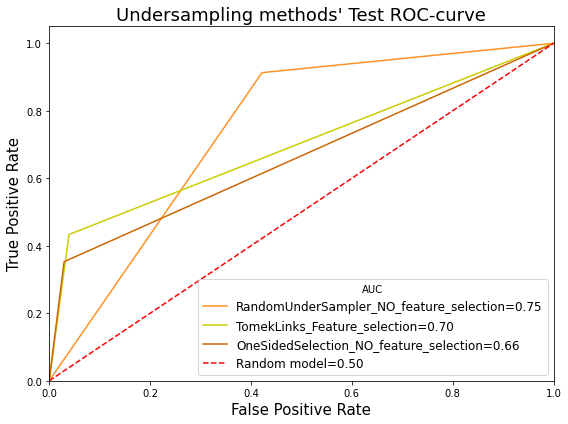

In [98]:
plot_all_roc_curves(diz_best_roc_curves, colors, type_flag, "Undersampling")